# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp

from salishsea_tools import nc_tools, geo_tools

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

### Hourly particle crossing, 1 day run

In [3]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/JDF_salish/14sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [4]:
def get_data(mydata, section, time):
    lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

#### SoG3

In [5]:
section = 4

figrid = 266 #fortran igrid
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

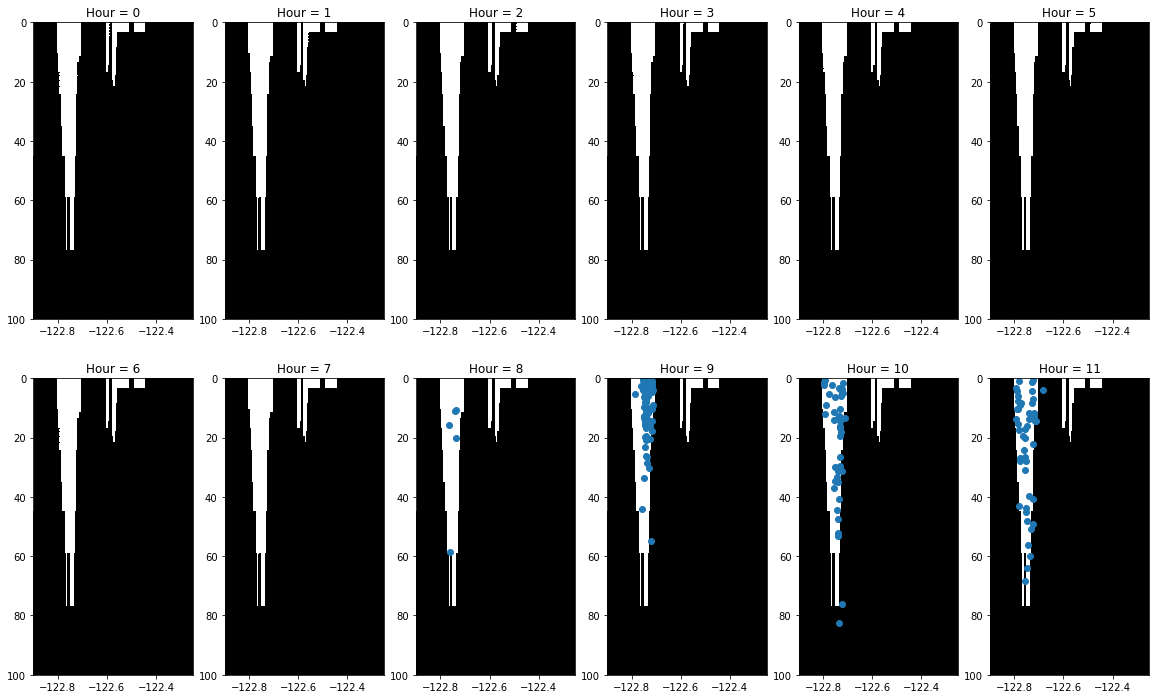

In [6]:

fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r',  shading='auto')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-122.9, -122.25))
    ax.set_ylim((100, 0))
    ax.set_title("Hour = "+str(hour))

clearly taking the figrid from sections.txt doesn't QUITE work (especially visible in hour 11 where many of the particles come in at a deph that is ground according to the grid)

## Daily flux, 1 day run

In [7]:
salfile = '/results/SalishSea/nowcast-green.201812/14sep17/SalishSea_1d_20170914_20170914_grid_T.nc'

### ALternative method: dont convert between longitude and m, that can be taken care of in cbar step using vmax

In [ ]:
def draw_patches(fmask, ll, ul, u_lons, w_depths): #draw ground part of cross section
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

In [90]:
def transportCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    t_lons = mymesh.glamt[0, igrid]    # longitude of T-grid points
    f_lons = mymesh.glamf[0, igrid]    # longitude of vorticity-grid points
    t_depths = mymesh.gdept_1d         # nominal depth of T-grid points
   
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum())) #look into whether this should be e2t or e1t
    tmax = 997
    vvmax = 0.23/float(m2lon)*24/tmax
    xs, ys = np.meshgrid(np.array(t_lons), np.array(t_depths))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
    vmax = vvmax*tmax/float(transports.sum())
    
    
    c, xedge, yedge, im = ax.hist2d(lons, 
                            depths,
                            weights=transports,
                            bins=[np.array(t_lons[lonW:lonE]), t_depths[0]], cmap=cm.matter, vmax=vmax, density=True)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_lons), np.array(t_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax*sum(transports)*m2lon).values),1)])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                    mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                    mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return c,xedge, yedge, transports, m2lon

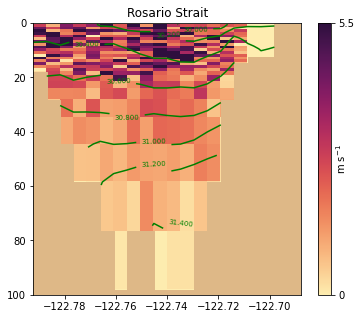

In [91]:
count, xedge, yedge, trans, m2lon = transportCS(4, 286, 307, 266, 100, "Rosario Strait")

In [13]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [74]:
def tranCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
    vmax = 0.0000065
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    c, xedge, yedge, im = ax.hist2d(dist, 
                            depths,
                            weights=transports, #so vmax is the conversion to m part? if we take it out with our conversion already done will it be the same as method 2?
                            bins=[np.array(t_dist[lonW:lonE]), t_depths], cmap=cm.matter, vmax = vmax, density=True, zorder=1) 
    
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
            mask=1-tmask[:, igrid]) +
            np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
            mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g', zorder = 2)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax*sum(transports)).values),1)])
    cb1.set_label('m s$^{-1}$', labelpad=-20)

    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()
    
    return c,xedge, yedge, transports, t_dist

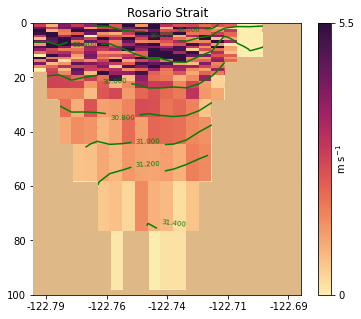

In [75]:
count, xedge, yedge, trans, t_dist = tranCS(4, 286, 307, 266, 100, "Rosario Strait")